# Important Library

We use the following libraries in this project:
* [Pandas](https://pandas.pydata.org/) - Data Analysis
* [Numpy](https://numpy.org/) - Data Analysis
* [Matplotlib](https://matplotlib.org/) - Data Visualization
* [Seaborn](https://seaborn.pydata.org/) - Data Visualization
* [Scikit-learn](https://scikit-learn.org/stable/) - Machine Learning
* [Tensorflow](https://www.tensorflow.org/) - Machine Learning
* [Keras](https://keras.io/) - Machine Learning

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

print(tf.__version__)
print(np.__version__)
print(sns.__version__)

2.12.0
1.23.5
0.12.2


# Exploring the Dataset

In [3]:
base_dir = './data/Vegetable Images'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training pictures
train_bean_dir = os.path.join(train_dir, 'Bean')
train_bitter_gourd_dir = os.path.join(train_dir, 'Bitter_Gourd')
train_bottle_gourd_dir = os.path.join(train_dir, 'Bottle_Gourd')
train_brinjal_dir = os.path.join(train_dir, 'Brinjal')
train_broccoli_dir = os.path.join(train_dir, 'Broccoli')
train_cabbage_dir = os.path.join(train_dir, 'Cabbage')
train_capsicum_dir = os.path.join(train_dir, 'Capsicum')
train_carrot_dir = os.path.join(train_dir, 'Carrot')
train_cauliflower_dir = os.path.join(train_dir, 'Cauliflower')
train_cucumber_dir = os.path.join(train_dir, 'Cucumber')
train_papaya_dir = os.path.join(train_dir, 'Papaya')
train_potato_dir = os.path.join(train_dir, 'Potato')
train_pumpkin_dir = os.path.join(train_dir, 'Pumpkin')
train_radish_dir = os.path.join(train_dir, 'Radish')
train_tomato_dir = os.path.join(train_dir, 'Tomato')

# Directory with our validation pictures
validation_bean_dir = os.path.join(validation_dir, 'Bean')
validation_bitter_gourd_dir = os.path.join(validation_dir, 'Bitter_Gourd')
validation_bottle_gourd_dir = os.path.join(validation_dir, 'Bottle_Gourd')
validation_brinjal_dir = os.path.join(validation_dir, 'Brinjal')
validation_broccoli_dir = os.path.join(validation_dir, 'Broccoli')
validation_cabbage_dir = os.path.join(validation_dir, 'Cabbage')
validation_capsicum_dir = os.path.join(validation_dir, 'Capsicum')
validation_carrot_dir = os.path.join(validation_dir, 'Carrot')
validation_cauliflower_dir = os.path.join(validation_dir, 'Cauliflower')
validation_cucumber_dir = os.path.join(validation_dir, 'Cucumber')
validation_papaya_dir = os.path.join(validation_dir, 'Papaya')
validation_potato_dir = os.path.join(validation_dir, 'Potato')
validation_pumpkin_dir = os.path.join(validation_dir, 'Pumpkin')
validation_radish_dir = os.path.join(validation_dir, 'Radish')
validation_tomato_dir = os.path.join(validation_dir, 'Tomato')

# Directory with our test pictures
test_bean_dir = os.path.join(test_dir, 'Bean')
test_bitter_gourd_dir = os.path.join(test_dir, 'Bitter_Gourd')
test_bottle_gourd_dir = os.path.join(test_dir, 'Bottle_Gourd')
test_brinjal_dir = os.path.join(test_dir, 'Brinjal')
test_broccoli_dir = os.path.join(test_dir, 'Broccoli')
test_cabbage_dir = os.path.join(test_dir, 'Cabbage')
test_capsicum_dir = os.path.join(test_dir, 'Capsicum')
test_carrot_dir = os.path.join(test_dir, 'Carrot')
test_cauliflower_dir = os.path.join(test_dir, 'Cauliflower')
test_cucumber_dir = os.path.join(test_dir, 'Cucumber')
test_papaya_dir = os.path.join(test_dir, 'Papaya')
test_potato_dir = os.path.join(test_dir, 'Potato')
test_pumpkin_dir = os.path.join(test_dir, 'Pumpkin')
test_radish_dir = os.path.join(test_dir, 'Radish')
test_tomato_dir = os.path.join(test_dir, 'Tomato')


Find how many images for each class in the training set

In [4]:
print('total training Bean images:', len(os.listdir(train_bean_dir)))
print('total training Bitter_Gourd images:', len(os.listdir(train_bitter_gourd_dir)))
print('total training Bottle_Gourd images:', len(os.listdir(train_bottle_gourd_dir)))
print('total training Brinjal images:', len(os.listdir(train_brinjal_dir)))
print('total training Broccoli images:', len(os.listdir(train_broccoli_dir)))
print('total training Cabbage images:', len(os.listdir(train_cabbage_dir)))
print('total training Capsicum images:', len(os.listdir(train_capsicum_dir)))
print('total training Carrot images:', len(os.listdir(train_carrot_dir)))
print('total training Cauliflower images:', len(os.listdir(train_cauliflower_dir)))
print('total training Cucumber images:', len(os.listdir(train_cucumber_dir)))
print('total training Papaya images:', len(os.listdir(train_papaya_dir)))
print('total training Potato images:', len(os.listdir(train_potato_dir)))
print('total training Pumpkin images:', len(os.listdir(train_pumpkin_dir)))
print('total training Radish images:', len(os.listdir(train_radish_dir)))
print('total training Tomato images:', len(os.listdir(train_tomato_dir)))

total training Bean images: 1000
total training Bitter_Gourd images: 1000
total training Bottle_Gourd images: 1000
total training Brinjal images: 1000
total training Broccoli images: 1000
total training Cabbage images: 1000
total training Capsicum images: 1000
total training Carrot images: 1000
total training Cauliflower images: 1000
total training Cucumber images: 1000
total training Papaya images: 1000
total training Potato images: 1000
total training Pumpkin images: 1000
total training Radish images: 1000
total training Tomato images: 1000


Find how many images for each class in the validation set

In [5]:
print('total validation Bean images:', len(os.listdir(validation_bean_dir)))
print('total validation Bitter_Gourd images:', len(os.listdir(validation_bitter_gourd_dir)))
print('total validation Bottle_Gourd images:', len(os.listdir(validation_bottle_gourd_dir)))
print('total validation Brinjal images:', len(os.listdir(validation_brinjal_dir)))
print('total validation Broccoli images:', len(os.listdir(validation_broccoli_dir)))
print('total validation Cabbage images:', len(os.listdir(validation_cabbage_dir)))
print('total validation Capsicum images:', len(os.listdir(validation_capsicum_dir)))
print('total validation Carrot images:', len(os.listdir(validation_carrot_dir)))
print('total validation Cauliflower images:', len(os.listdir(validation_cauliflower_dir)))
print('total validation Cucumber images:', len(os.listdir(validation_cucumber_dir)))
print('total validation Papaya images:', len(os.listdir(validation_papaya_dir)))
print('total validation Potato images:', len(os.listdir(validation_potato_dir)))
print('total validation Pumpkin images:', len(os.listdir(validation_pumpkin_dir)))
print('total validation Radish images:', len(os.listdir(validation_radish_dir)))
print('total validation Tomato images:', len(os.listdir(validation_tomato_dir)))

total validation Bean images: 200
total validation Bitter_Gourd images: 200
total validation Bottle_Gourd images: 200
total validation Brinjal images: 200
total validation Broccoli images: 200
total validation Cabbage images: 200
total validation Capsicum images: 200
total validation Carrot images: 200
total validation Cauliflower images: 200
total validation Cucumber images: 200
total validation Papaya images: 200
total validation Potato images: 200
total validation Pumpkin images: 200
total validation Radish images: 200
total validation Tomato images: 200


Find how many images for eash class in the test set

In [6]:
print('total test Bean images:', len(os.listdir(test_bean_dir)))
print('total test Bitter_Gourd images:', len(os.listdir(test_bitter_gourd_dir)))
print('total test Bottle_Gourd images:', len(os.listdir(test_bottle_gourd_dir)))
print('total test Brinjal images:', len(os.listdir(test_brinjal_dir)))
print('total test Broccoli images:', len(os.listdir(test_broccoli_dir)))
print('total test Cabbage images:', len(os.listdir(test_cabbage_dir)))
print('total test Capsicum images:', len(os.listdir(test_capsicum_dir)))
print('total test Carrot images:', len(os.listdir(test_carrot_dir)))
print('total test Cauliflower images:', len(os.listdir(test_cauliflower_dir)))
print('total test Cucumber images:', len(os.listdir(test_cucumber_dir)))
print('total test Papaya images:', len(os.listdir(test_papaya_dir)))
print('total test Potato images:', len(os.listdir(test_potato_dir)))
print('total test Pumpkin images:', len(os.listdir(test_pumpkin_dir)))
print('total test Radish images:', len(os.listdir(test_radish_dir)))
print('total test Tomato images:', len(os.listdir(test_tomato_dir)))

total test Bean images: 200
total test Bitter_Gourd images: 200
total test Bottle_Gourd images: 200
total test Brinjal images: 200
total test Broccoli images: 200
total test Cabbage images: 200
total test Capsicum images: 200
total test Carrot images: 200
total test Cauliflower images: 200
total test Cucumber images: 200
total test Papaya images: 200
total test Potato images: 200
total test Pumpkin images: 200
total test Radish images: 200
total test Tomato images: 200


# Creating Small Model

In [7]:
model = tf.keras.models.Sequential([
    # Layer 1
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Layer 2
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Layer 3
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Layer 4
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Layer 5
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    #Layer 6
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
       
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),

    # 512 neuron hidden layer
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),

    # 15 output neurons for 15 classes with the softmax activation
    tf.keras.layers.Dense(15, activation='softmax')
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Data Preprocessing

In [10]:
from keras.preprocessing.image import ImageDataGenerator

# Rescale all images by 1./255 and apply image augmentation
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=128, class_mode='categorical', target_size=(224, 224))

# Rescale all images by 1./255 and apply image augmentation
validation_datagen = ImageDataGenerator(rescale=1. / 255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,)

# Flow validation images in batches of 128 using validation_datagen generator
validation_generator = validation_datagen.flow_from_directory(validation_dir, batch_size=128, class_mode='categorical', target_size=(224, 224))

# Rescale all images by 1./255 and apply image augmentation
test_datagen = ImageDataGenerator(rescale=1. / 255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,)

# Flow test images in batches of 128 using test_datagen generator
test_generator = test_datagen.flow_from_directory(test_dir, batch_size=128, class_mode='categorical', target_size=(224, 224))

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


# Training the Model

In [11]:
# tensorboard
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

history = model.fit(train_generator, 
                    epochs=100, # changed later 
                    steps_per_epoch=20, 
                    validation_data=validation_generator, 
                    callbacks=[tensorboard_callback],
                    verbose=1, 
                    validation_steps=3)

Epoch 1/100
20/20 [==============================] - 89s 4s/step - loss: 2.5614 - accuracy: 0.1121 - val_loss: 2.3097 - val_accuracy: 0.2266
Epoch 2/100
20/20 [==============================] - 84s 4s/step - loss: 2.1619 - accuracy: 0.2035 - val_loss: 2.0379 - val_accuracy: 0.2344
Epoch 3/100
20/20 [==============================] - 78s 4s/step - loss: 1.9165 - accuracy: 0.3023 - val_loss: 1.8251 - val_accuracy: 0.3333
Epoch 4/100
20/20 [==============================] - 71s 4s/step - loss: 1.7799 - accuracy: 0.3402 - val_loss: 1.7340 - val_accuracy: 0.3594
Epoch 5/100
20/20 [==============================] - 63s 3s/step - loss: 1.6891 - accuracy: 0.3766 - val_loss: 1.5113 - val_accuracy: 0.4583
Epoch 6/100
20/20 [==============================] - 60s 3s/step - loss: 1.6198 - accuracy: 0.4169 - val_loss: 1.6544 - val_accuracy: 0.4297
Epoch 7/100
20/20 [==============================] - 67s 3s/step - loss: 1.5650 - accuracy: 0.4242 - val_loss: 1.6053 - val_accuracy: 0.4271
Epoch 8/100
2

# Model Evaluation

<Figure size 640x480 with 0 Axes>

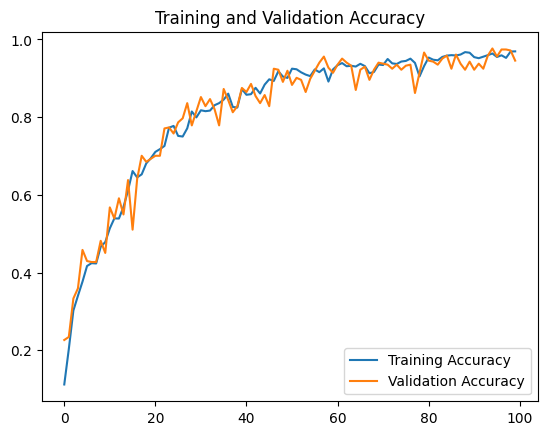

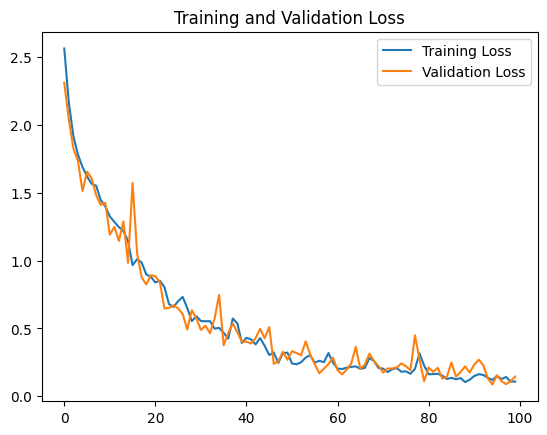

<Figure size 640x480 with 0 Axes>

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.figure()

In [13]:
# Evaluate the model with the test dataset
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('\nTest accuracy:', test_acc)

24/24 - 57s - loss: 0.1521 - accuracy: 0.9550 - 57s/epoch - 2s/step

Test accuracy: 0.9549999833106995


In [22]:
# Load the trained model
model = tf.keras.models.load_model('./vegetable_classification_model.h5')

# Preprocess the input image
image_path = './data/Vegetable Images/test/Carrot/1001.jpg'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image_array = tf.keras.preprocessing.image.img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)
image_array = image_array / 255.0  # Normalize the pixel values

# Perform the prediction
prediction = model.predict(image_array)

# Interpret the results
predicted_class_index = np.argmax(prediction)
class_names = ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjai', 'Brocolli', 'Cabbage', 'Capsicium', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']  # Add your class names here
predicted_class_name = class_names[predicted_class_index]

# Display the predicted class
print("Predicted class:", predicted_class_name)


1/1 [==============================] - 0s 188ms/step
Predicted class: Carrot


In [20]:
# Save the model
model.save('vegetable_classification_model.h5')